In [1]:
!pip install optuna --quiet

In [2]:
from functools import partial
import os
import json
import tempfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
import torchaudio
import torchaudio.transforms as T

import optuna

False


/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.11/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 500: named symbol not found (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# Load waveforms and create dataset


def pad_tensor(tensor, target_length):
    # Pad the tensor to the target length
    padding = target_length - tensor.shape[-1]
    if padding > 0:
        tensor = torch.nn.functional.pad(tensor, (0, padding))
    return tensor


def create_tensor_dataset(directories):   # Create labeled tensor dataset from PSUH directory
    # Initialize lists
    audio_tensors = []
    filepaths = []
    for directory in directories:
        for filename in os.listdir(directory):
            try:
                file_path = os.path.join(directory, filename)
                # Load audio file
                waveform, sample_rate = torchaudio.load(filename)
                # Get spectrogram of waveform and transform to tensor
                spectrogram_transform = T.Spectrogram()
                spectrogram = spectrogram_transform(waveform)
                # Add tensor to list
                audio_tensors.append(spectrogram)
                # Add filepath to list
                filepaths.append(file_path)
            except (RuntimeError, OSError) as e:
                print(f"An error occurred with {filename}: {e}")
                continue
            
    # Assign labels based on filepath name (pre = 0, dc = 1, post = 2)
    labels = [0 if 'pre' in s else 1 if 'dc' in s else 2 if 'post' in s else -1 for s in filepaths]

    # Find the maximum length of the waveforms
    max_length = max(waveform.shape[-1] for waveform in audio_tensors)
    # Pad all waveforms to the maximum length
    padded_waveforms = [pad_tensor(waveform, max_length) for waveform in audio_tensors]
    # Convert lists to tensors
    audio_tensors = torch.stack(padded_waveforms)
    labels = torch.tensor(labels)
    # Create TensorDataset
    dataset = TensorDataset(audio_tensors, labels)
    return filepaths, labels, dataset



In [4]:
# Define normalized utterance directories
pre_norm = "PSUH/NR/pre/segment/normalized/"
post_norm = "PSUH/NR/post/segment/normalized/"
dc_norm = "PSUH/NR/dc/segment/normalized/"
directories = [pre_norm, post_norm, dc_norm]
# Create TensorDataset
PSUH_paths, PSUH_labels, PSUH_ds = create_tensor_dataset(directories)
PSUH_ds[0][0].shape

An error occurred with 05pre_nr_10.wav: Error opening '05pre_nr_10.wav': System error.
An error occurred with 17post_nr_1.wav: Error opening '17post_nr_1.wav': System error.
An error occurred with 36dc_nr_3.wav: Error opening '36dc_nr_3.wav': System error.


torch.Size([1, 201, 219])

In [5]:
### Split into train / val / test datasets
# Load previously created indices
with open('PSUH/train_indices.json', 'r') as file:
    train_indices = json.load(file)

with open('PSUH/val_indices.json', 'r') as file:
    val_indices = json.load(file)
    
with open('PSUH/test_indices.json', 'r') as file:
    test_indices = json.load(file)

# Create subsets
train_dataset = Subset(PSUH_ds, train_indices)
val_dataset = Subset(PSUH_ds, val_indices)
test_dataset = Subset(PSUH_ds, test_indices)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Create ResNet model

Architecture based on https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [56]:

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


# Example usage
model = ResNet18()
print(model)

ResNet18(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [7]:
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    
    # Load dataset
    train_dataset = Subset(PSUH_ds, train_indices)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    model = ResNet18()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop (10 epoch for simplicity)
    model.train()
    for epoch in range(10):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    return loss.item()

In [8]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print("Best Hyperparameters:", study.best_params)

[I 2024-10-19 23:44:00,803] A new study created in memory with name: no-name-54a487fd-117b-4d20-b5b8-0006bd99fa56
[I 2024-10-19 23:45:49,498] Trial 0 finished with value: 0.40516215562820435 and parameters: {'lr': 2.6454479896099518e-05}. Best is trial 0 with value: 0.40516215562820435.
[I 2024-10-19 23:47:39,585] Trial 1 finished with value: 0.989467978477478 and parameters: {'lr': 0.006853589634487472}. Best is trial 0 with value: 0.40516215562820435.
[I 2024-10-19 23:49:30,314] Trial 2 finished with value: 0.6509125232696533 and parameters: {'lr': 0.0007230039085240577}. Best is trial 0 with value: 0.40516215562820435.
[I 2024-10-19 23:51:20,323] Trial 3 finished with value: 0.16518685221672058 and parameters: {'lr': 0.00012351663930726875}. Best is trial 3 with value: 0.16518685221672058.
[I 2024-10-19 23:53:10,115] Trial 4 finished with value: 0.14812281727790833 and parameters: {'lr': 8.558209585501573e-05}. Best is trial 4 with value: 0.14812281727790833.
[I 2024-10-19 23:55:00,

Best Hyperparameters: {'lr': 8.558209585501573e-05}


In [57]:
model = ResNet18()

Epoch 1/30, Training Loss: 0.97212, Validation Loss: 0.88576, Training Accuracy: 62.069%, Validation Accuracy: 63.248%
Epoch 2/30, Training Loss: 0.84316, Validation Loss: 0.91337, Training Accuracy: 65.733%, Validation Accuracy: 63.248%
Epoch 3/30, Training Loss: 0.78518, Validation Loss: 0.94616, Training Accuracy: 68.75%, Validation Accuracy: 63.248%
Epoch 4/30, Training Loss: 0.70578, Validation Loss: 0.87901, Training Accuracy: 73.707%, Validation Accuracy: 66.667%
Epoch 5/30, Training Loss: 0.5665, Validation Loss: 1.8712, Training Accuracy: 79.095%, Validation Accuracy: 52.137%
Epoch 6/30, Training Loss: 0.49077, Validation Loss: 1.6484, Training Accuracy: 82.112%, Validation Accuracy: 64.103%
Epoch 7/30, Training Loss: 0.44923, Validation Loss: 1.0706, Training Accuracy: 83.836%, Validation Accuracy: 63.248%
Epoch 8/30, Training Loss: 0.35214, Validation Loss: 0.94042, Training Accuracy: 86.853%, Validation Accuracy: 69.231%
Epoch 9/30, Training Loss: 0.29841, Validation Loss: 

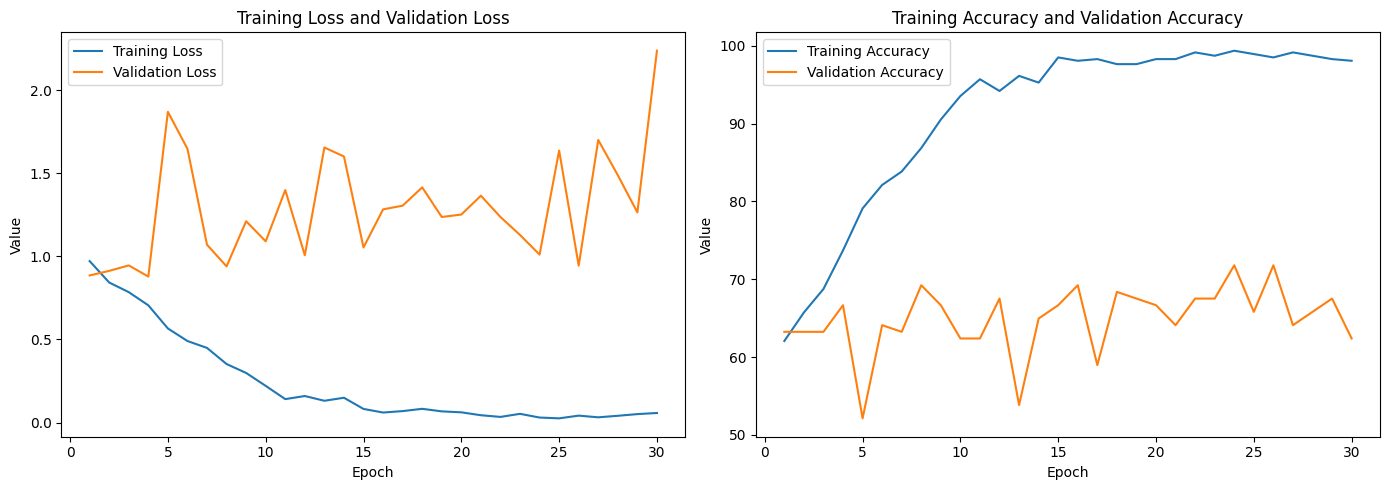

In [58]:
# Set loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=8.56e-05)

# Initialize lists to store loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 30

for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * train_correct / train_total)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {(running_loss/len(train_loader)):.5g}, Validation Loss: {(val_loss/len(val_loader)):.5g}, Training Accuracy: {(100 * train_correct / train_total):.5g}%, Validation Accuracy: {(100 * val_correct / val_total):.5g}%')

# Plotting the results
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
def evaluate_dataset(dataset_loader, model=model):
    model.eval()
    
    correct = 0
    total = 0
    incorrect_idx_dataset = []
    correct_idx_dataset = []
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():  # No need to track gradients
        for batch_idx, (inputs, labels) in enumerate(dataset_loader):
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
            # Collect correct and incorrect indices
            for i, (pred, label) in enumerate(zip(predicted, labels)):
                if pred == label:
                    correct_idx_dataset.append(batch_idx * dataset_loader.batch_size + i)
                else:
                    incorrect_idx_dataset.append(batch_idx * dataset_loader.batch_size + i)
                # Append to true and predicted labels list
                true_labels.append(label.item())
                pred_labels.append(pred.item())
                
    accuracy = 100 * correct / total
    print(f'Accuracy on dataset: {accuracy:.2f}%')
    return correct_idx_dataset, incorrect_idx_dataset, pred_labels, true_labels

In [48]:
correct_idx_train, incorrect_idx_train, pred_labels_train, true_labels_train = evaluate_dataset(train_loader)

Accuracy on dataset: 100.00%


In [49]:
correct_idx_val, incorrect_idx_val, pred_labels_val, true_labels_val = evaluate_dataset(val_loader)

Accuracy on dataset: 67.52%


In [50]:
correct_idx_test, incorrect_idx_test, pred_labels_test, true_labels_test = evaluate_dataset(test_loader)

Accuracy on dataset: 67.81%


In [51]:
incorrect_idx_test[0:4]

[3, 7, 9, 12]

In [52]:
correct_idx_test[0:4]

[0, 1, 2, 4]

In [53]:
len(incorrect_idx_test)

47

In [54]:
len(correct_idx_test)

99

In [55]:
len(test_indices)

146

In [23]:
# Identify which audio files are classified correctly/incorrectly using the original dataset indices
train_indices_correct = [train_indices[i] for i in correct_idx_train]
train_indices_incorrect = [train_indices[i] for i in incorrect_idx_train]
val_indices_correct = [val_indices[i] for i in correct_idx_val]
val_indices_incorrect = [val_indices[i] for i in incorrect_idx_val]
test_indices_correct = [test_indices[i] for i in correct_idx_test]
test_indices_incorrect = [test_indices[i] for i in incorrect_idx_test]

In [24]:
len(test_indices_correct)

99

In [25]:
# Group all correct/incorrect indices together 
all_correct = train_indices_correct + val_indices_correct + test_indices_correct
all_incorrect = train_indices_incorrect + val_indices_incorrect + test_indices_incorrect
# Sort indices
all_correct.sort()
all_incorrect.sort()

In [26]:
all_correct[0:5]

[0, 2, 3, 4, 5]

In [27]:
all_incorrect[0:5]

[1, 25, 52, 70, 99]

In [28]:
print(len(all_correct))
print(len(all_incorrect))

642
85


In [29]:
len(PSUH_paths)

727

In [30]:
# Get corresponding filenames for correct/incorrect indices
correct_files = [PSUH_paths[i] for i in all_correct]
incorrect_files = [PSUH_paths[i] for i in all_incorrect]
# Sort indices
correct_files.sort()
incorrect_files.sort()

In [31]:
import re
import pandas as pd
from collections import Counter


def summarize_list(target_list):
    result_list = []
    for item in target_list:
        match = re.search(r'(?:.*?/){5}(\d{2}[a-zA-Z]{2,4})_', item)
        if match:
            result_list.append(match.group(1))
            
    id_counts = Counter()
    status_counts = Counter()
    
    for item in result_list:
        numeric_part = item[:2]
        char_part = item[2:]
        id_counts[numeric_part] += 1
        status_counts[char_part] += 1
    
    # Prepare data for DataFrame
    data = {char: [] for char in status_counts.keys()}
    for num in id_counts.keys():
        for char in status_counts.keys():
            count = result_list.count(num + char)
            data[char].append(count)
    
    # Create DataFrame
    df = pd.DataFrame(data, index=id_counts.keys())
    return df

In [32]:
utterances_correct = summarize_list(correct_files)
utterances_incorrect = summarize_list(incorrect_files)

In [33]:
# Calculate accuracy dataframe
acc_utterances = (utterances_correct / (utterances_correct + utterances_incorrect)) * 100
acc_utterances.fillna(0, inplace=True)

In [34]:
acc_utterances.mean()

dc      45.833333
post    52.604167
pre     72.841435
dtype: float64

In [35]:
pred_labels_train[0:10]

[0, 1, 0, 2, 0, 2, 1, 0, 1, 2]

In [36]:
true_labels_train[0:10]

[0, 1, 0, 2, 0, 2, 1, 0, 1, 2]

In [37]:
print(len(pred_labels_train))
print(len(true_labels_train))

464
464


In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd


def evaluate_labels(true_labels, predicted_labels, title):
    labels = ['pre', 'dc', 'post']
    # Create confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.title("Confusion Matrix: " + title)
    plt.show()
    print(classification_report(true_labels, predicted_labels))

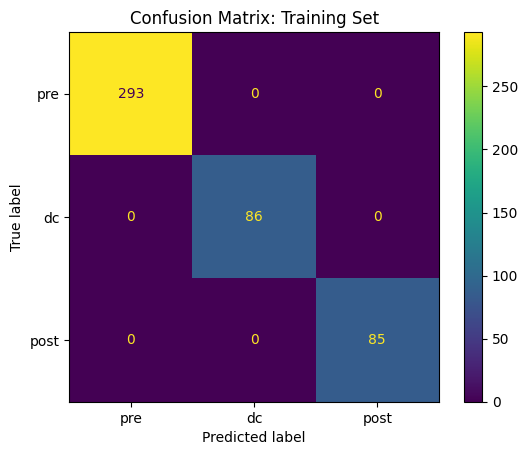

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       293
           1       1.00      1.00      1.00        86
           2       1.00      1.00      1.00        85

    accuracy                           1.00       464
   macro avg       1.00      1.00      1.00       464
weighted avg       1.00      1.00      1.00       464



In [39]:
evaluate_labels(true_labels_train, pred_labels_train, 'Training Set')

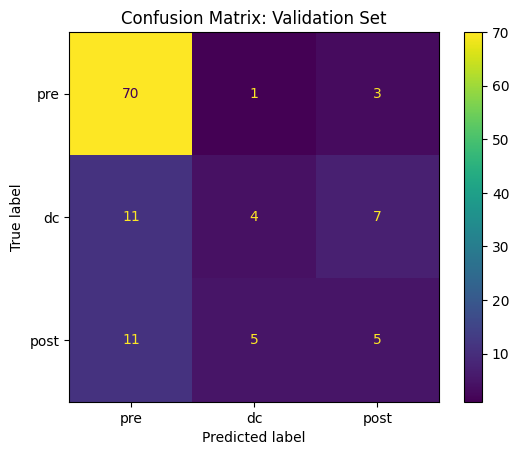

              precision    recall  f1-score   support

           0       0.76      0.95      0.84        74
           1       0.40      0.18      0.25        22
           2       0.33      0.24      0.28        21

    accuracy                           0.68       117
   macro avg       0.50      0.46      0.46       117
weighted avg       0.62      0.68      0.63       117



In [40]:
evaluate_labels(true_labels_val, pred_labels_val, 'Validation Set')

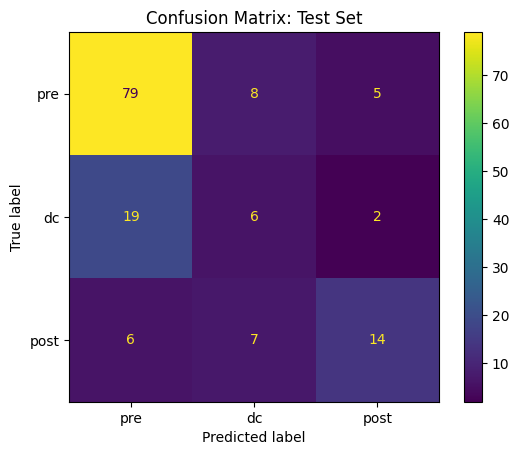

              precision    recall  f1-score   support

           0       0.76      0.86      0.81        92
           1       0.29      0.22      0.25        27
           2       0.67      0.52      0.58        27

    accuracy                           0.68       146
   macro avg       0.57      0.53      0.55       146
weighted avg       0.65      0.68      0.66       146



In [41]:
evaluate_labels(true_labels_test, pred_labels_test, 'Test Set')

### Save dataset indices

In [60]:
train_indices[0:5]

[547, 44, 131, 218, 568]

In [62]:
import json
os.getcwd()

'/home/patrick/ssr'

In [63]:
with open('PSUH/train_indices.json', 'w') as f:
    json.dump(train_indices, f, indent=4)

In [64]:
with open('PSUH/val_indices.json', 'w') as f:
    json.dump(val_indices, f, indent=4)

In [65]:
with open('PSUH/test_indices.json', 'w') as f:
    json.dump(test_indices, f, indent=4)

### Save model

In [59]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('models/ResNet18_PSUH_multiclass.pt') # Save